In [10]:
# ============================================
# 1. IMPORTS & CONFIG
# ============================================
import json
from pathlib import Path

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)

# ----------------------------
# CONFIG – CHANGE THIS PATH
# ----------------------------
DATASET_DIR = Path(r"E:\Snake_Identification_Folder\snake_identification.v9-10_classes_balanced_v4.coco")
OUTPUT_DIR  = DATASET_DIR / "processed_crops_224"   # cropped images will go here
TARGET_SIZE = (320, 320)                           # for MobileNetV3
BATCH_SIZE  = 32
# ----------------------------

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATASET_DIR:", DATASET_DIR)
print("OUTPUT_DIR :", OUTPUT_DIR)


DATASET_DIR: E:\Snake_Identification_Folder\snake_identification.v9-10_classes_balanced_v4.coco
OUTPUT_DIR : E:\Snake_Identification_Folder\snake_identification.v9-10_classes_balanced_v4.coco\processed_crops_224


In [12]:
# ============================================
# 2. COCO → CROPPED SPECIES FOLDERS
# ============================================

def process_split(split_name: str):
    """
    Read split (train/valid/test), crop each bbox, save to class folders.
    """
    split_dir = DATASET_DIR / split_name
    annot_path = split_dir / "_annotations.coco.json"

    print(f"\n=== Processing split: {split_name} ===")
    print("Annotations:", annot_path)

    with open(annot_path, "r") as f:
        coco = json.load(f)

    # Map image_id -> file_name
    id_to_file = {img["id"]: img["file_name"] for img in coco["images"]}

    # Map category_id -> class_name
    id_to_class = {cat["id"]: cat["name"] for cat in coco["categories"]}

    # Prepare output base for this split
    split_out_dir = OUTPUT_DIR / split_name
    split_out_dir.mkdir(parents=True, exist_ok=True)

    # Counters per class just for info
    per_class_count = {}

    for ann in coco["annotations"]:
        image_id = ann["image_id"]
        category_id = ann["category_id"]
        bbox = ann["bbox"]  # [x, y, width, height]

        class_name = id_to_class[category_id]
        file_name = id_to_file[image_id]
        img_path = split_dir / file_name

        # Open image and crop
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Failed to open {img_path}: {e}")
            continue

        x, y, w, h = bbox
        # COCO bboxes: x, y, w, h in pixels
        left   = int(x)
        top    = int(y)
        right  = int(x + w)
        bottom = int(y + h)

        # Safety clamp
        left   = max(left, 0)
        top    = max(top, 0)
        right  = min(right, img.width)
        bottom = min(bottom, img.height)

        if right <= left or bottom <= top:
            continue

        crop = img.crop((left, top, right, bottom))
        crop = crop.resize(TARGET_SIZE, Image.BILINEAR)

        # Prepare class folder
        class_dir = split_out_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)

        # Unique filename
        out_name = f"{Path(file_name).stem}_ann{ann['id']}.jpg"
        out_path = class_dir / out_name

        try:
            crop.save(out_path, quality=95)
        except Exception as e:
            print(f"Failed to save {out_path}: {e}")
            continue

        per_class_count[class_name] = per_class_count.get(class_name, 0) + 1

    print(f"Done {split_name}. Crops per class:")
    for cls, cnt in sorted(per_class_count.items(), key=lambda x: -x[1]):
        print(f"  {cls}: {cnt}")


# Run this ONCE to generate the cropped dataset.
# If you've already run it and don't want to overwrite, you can skip this cell.
for split in ["train", "valid", "test"]:
    process_split(split)

print("\n✅ Finished creating cropped dataset at:", OUTPUT_DIR)



=== Processing split: train ===
Annotations: E:\Snake_Identification_Folder\snake_identification.v9-10_classes_balanced_v4.coco\train\_annotations.coco.json
Done train. Crops per class:
  ophiophagus_hannah: 1842
  indotyphlops_braminus: 1427
  laticauda_colubrina: 1410
  gonyosoma_oxycephalum: 1380
  lycodon_capucinus: 1314
  psammodynastes_pulverulentus: 1152
  malayopython_reticulatus: 1110
  cerberus_schneiderii: 1083
  dendrelaphis_pictus: 1008
  tropidolaemus_subannulatus: 933

=== Processing split: valid ===
Annotations: E:\Snake_Identification_Folder\snake_identification.v9-10_classes_balanced_v4.coco\valid\_annotations.coco.json
Done valid. Crops per class:
  ophiophagus_hannah: 306
  indotyphlops_braminus: 250
  gonyosoma_oxycephalum: 227
  laticauda_colubrina: 205
  lycodon_capucinus: 202
  dendrelaphis_pictus: 194
  tropidolaemus_subannulatus: 187
  psammodynastes_pulverulentus: 150
  malayopython_reticulatus: 148
  cerberus_schneiderii: 145

=== Processing split: test ===

In [11]:
# ============================================
# 3. LOAD DATASETS (train / valid / test)
# ============================================
from pathlib import Path
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

data_root = OUTPUT_DIR  # same as above
img_size = TARGET_SIZE
batch_size = BATCH_SIZE

AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_root / "train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_root / "valid",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_root / "test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False,
)

class_names = train_ds.class_names
num_classes = len(class_names)

print("Classes:", class_names)
print("Number of classes:", num_classes)

def preprocess(image, label):
    image = preprocess_input(image)  # scales to [-1, 1] with proper normalization
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 12659 files belonging to 10 classes.
Found 2014 files belonging to 10 classes.
Found 1577 files belonging to 10 classes.
Classes: ['cerberus_schneiderii', 'dendrelaphis_pictus', 'gonyosoma_oxycephalum', 'indotyphlops_braminus', 'laticauda_colubrina', 'lycodon_capucinus', 'malayopython_reticulatus', 'ophiophagus_hannah', 'psammodynastes_pulverulentus', 'tropidolaemus_subannulatus']
Number of classes: 10


In [12]:
# ============================================
# 4. BUILD & TRAIN MOBILENETV3 MODEL (with callbacks)
# ============================================

# Base MobileNetV3Large
base = tf.keras.applications.MobileNetV3Large(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet",
    pooling="avg",
)

# Optional: freeze some layers at first
for layer in base.layers:
    layer.trainable = False  

inputs = base.input
x = tf.keras.layers.Dropout(0.3)(base.output)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# label smoothing still applied
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss,
    metrics=["accuracy"],
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 320, 320,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 160, 160,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 160, 160,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 160, 160,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 160, 160,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 161, 161,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        256 │ expanded_conv_1_

 Total params: 3,005,962 (11.47 MB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [13]:
# stage 1: train top layers only (base frozen)
# ----------------------------
# Callbacks
# ----------------------------
checkpoint_path = "best_mobilenetv3_snakes.h5"

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,              # epochs with no improvement before stopping
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,              # reduce LR by this factor
    patience=3,              # epochs with no improvement before reducing LR
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop_cb, checkpoint_cb, reduce_lr_cb]

# ----------------------------
# Training
# ----------------------------

history_stage1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks,
)

Epoch 1/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1979 - loss: 2.4932
Epoch 1: val_loss improved from None to 1.45737, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 181s 448ms/step - accuracy: 0.2822 - loss: 2.1697 - val_accuracy: 0.5641 - val_loss: 1.4574 - learning_rate: 1.0000e-04
Epoch 2/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5195 - loss: 1.5130
Epoch 2: val_loss improved from 1.45737 to 1.13413, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 167s 421ms/step - accuracy: 0.5505 - loss: 1.4404 - val_accuracy: 0.6847 - val_loss: 1.1341 - learning_rate: 1.0000e-04
Epoch 3/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6314 - loss: 1.2268
Epoch 3: val_loss improved from 1.13413 to 1.01302, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 167s 421ms/step - accuracy: 0.6492 - loss: 1.2018 - val_accuracy: 0.7244 - val_loss: 1.0130 - learning_rate: 1.0000e-04
Epoch 4/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6842 - loss: 1.1059
Epoch 4: val_loss improved from 1.01302 to 0.94748, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 164s 414ms/step - accuracy: 0.6946 - loss: 1.0861 - val_accuracy: 0.7532 - val_loss: 0.9475 - learning_rate: 1.0000e-04
Epoch 5/5
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7184 - loss: 1.0170
Epoch 5: val_loss improved from 0.94748 to 0.91040, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 165s 417ms/step - accuracy: 0.7256 - loss: 1.0141 - val_accuracy: 0.7701 - val_loss: 0.9104 - learning_rate: 1.0000e-04


In [14]:

# Stage 2 – unfreeze last part of backbone
for layer in base.layers[-60:]:   # for example, last 60 layers
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss= loss,
    metrics=["accuracy"],
)

history_stage2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    callbacks=[early_stop_cb, checkpoint_cb, reduce_lr_cb],
)

Epoch 1/45


396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.7471 - loss: 0.9531
Epoch 1: val_loss improved from 0.91040 to 0.72947, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 270s 665ms/step - accuracy: 0.8116 - loss: 0.8096 - val_accuracy: 0.8431 - val_loss: 0.7295 - learning_rate: 1.0000e-04
Epoch 2/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9296 - loss: 0.5288
Epoch 2: val_loss improved from 0.72947 to 0.66643, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 262s 661ms/step - accuracy: 0.9408 - loss: 0.5024 - val_accuracy: 0.8724 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 3/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9762 - loss: 0.4162
Epoch 3: val_loss improved from 0.66643 to 0.62991, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 255s 643ms/step - accuracy: 0.9797 - loss: 0.4057 - val_accuracy: 0.8893 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 4/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9900 - loss: 0.3711
Epoch 4: val_loss improved from 0.62991 to 0.60347, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 261s 660ms/step - accuracy: 0.9912 - loss: 0.3659 - val_accuracy: 0.8952 - val_loss: 0.6035 - learning_rate: 1.0000e-04
Epoch 5/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.9974 - loss: 0.3448
Epoch 5: val_loss improved from 0.60347 to 0.59544, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 266s 671ms/step - accuracy: 0.9976 - loss: 0.3426 - val_accuracy: 0.8957 - val_loss: 0.5954 - learning_rate: 1.0000e-04
Epoch 6/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9979 - loss: 0.3362
Epoch 6: val_loss did not improve from 0.59544
396/396 ━━━━━━━━━━━━━━━━━━━━ 261s 660ms/step - accuracy: 0.9985 - loss: 0.3340 - val_accuracy: 0.8962 - val_loss: 0.5973 - learning_rate: 1.0000e-04
Epoch 7/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9993 - loss: 0.3251
Epoch 7: val_loss improved from 0.59544 to 0.58749, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 261s 659ms/step - accuracy: 0.9993 - loss: 0.3245 - val_accuracy: 0.8962 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 8/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9987 - loss: 0.3218
Epoch 8: val_loss improved from 0.58749 to 0.58239, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 256s 646ms/step - accuracy: 0.9991 - loss: 0.3199 - val_accuracy: 0.9017 - val_loss: 0.5824 - learning_rate: 1.0000e-04
Epoch 9/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9996 - loss: 0.3139
Epoch 9: val_loss improved from 0.58239 to 0.57606, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 251s 635ms/step - accuracy: 0.9998 - loss: 0.3129 - val_accuracy: 0.9002 - val_loss: 0.5761 - learning_rate: 1.0000e-04
Epoch 10/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9999 - loss: 0.3115
Epoch 10: val_loss did not improve from 0.57606
396/396 ━━━━━━━━━━━━━━━━━━━━ 252s 638ms/step - accuracy: 0.9997 - loss: 0.3109 - val_accuracy: 0.9032 - val_loss: 0.5774 - learning_rate: 1.0000e-04
Epoch 11/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9996 - loss: 0.3087
Epoch 11: val_loss improved from 0.57606 to 0.56327, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 638ms/step - accuracy: 0.9998 - loss: 0.3085 - val_accuracy: 0.9086 - val_loss: 0.5633 - learning_rate: 1.0000e-04
Epoch 12/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9998 - loss: 0.3058
Epoch 12: val_loss did not improve from 0.56327
396/396 ━━━━━━━━━━━━━━━━━━━━ 252s 637ms/step - accuracy: 0.9997 - loss: 0.3056 - val_accuracy: 0.9017 - val_loss: 0.5735 - learning_rate: 1.0000e-04
Epoch 13/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 1.0000 - loss: 0.3032
Epoch 13: val_loss did not improve from 0.56327
396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 638ms/step - accuracy: 1.0000 - loss: 0.3028 - val_accuracy: 0.9037 - val_loss: 0.5666 - learning_rate: 1.0000e-04
Epoch 14/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 1.0000 - loss: 0.3009
Epoch 14: val_loss did not improve from 0.56327

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 639ms/step - accuracy: 1.0000 

396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 640ms/step - accuracy: 0.9999 - loss: 0.2986 - val_accuracy: 0.9067 - val_loss: 0.5541 - learning_rate: 5.0000e-05
Epoch 16/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 1.0000 - loss: 0.2977
Epoch 16: val_loss did not improve from 0.55415
396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 639ms/step - accuracy: 1.0000 - loss: 0.2973 - val_accuracy: 0.9067 - val_loss: 0.5554 - learning_rate: 5.0000e-05
Epoch 17/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 1.0000 - loss: 0.2968
Epoch 17: val_loss improved from 0.55415 to 0.55412, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 254s 641ms/step - accuracy: 1.0000 - loss: 0.2965 - val_accuracy: 0.9052 - val_loss: 0.5541 - learning_rate: 5.0000e-05
Epoch 18/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 1.0000 - loss: 0.2963
Epoch 18: val_loss improved from 0.55412 to 0.54985, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 253s 640ms/step - accuracy: 1.0000 - loss: 0.2960 - val_accuracy: 0.9086 - val_loss: 0.5499 - learning_rate: 5.0000e-05
Epoch 19/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 1.0000 - loss: 0.2955
Epoch 19: val_loss improved from 0.54985 to 0.54868, saving model to best_mobilenetv3_snakes.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 254s 641ms/step - accuracy: 0.9999 - loss: 0.2959 - val_accuracy: 0.9106 - val_loss: 0.5487 - learning_rate: 5.0000e-05
Epoch 20/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9999 - loss: 0.2951
Epoch 20: val_loss did not improve from 0.54868
396/396 ━━━━━━━━━━━━━━━━━━━━ 254s 641ms/step - accuracy: 0.9998 - loss: 0.2951 - val_accuracy: 0.9062 - val_loss: 0.5547 - learning_rate: 5.0000e-05
Epoch 21/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9999 - loss: 0.2944
Epoch 21: val_loss did not improve from 0.54868
396/396 ━━━━━━━━━━━━━━━━━━━━ 254s 641ms/step - accuracy: 0.9999 - loss: 0.2943 - val_accuracy: 0.9022 - val_loss: 0.5592 - learning_rate: 5.0000e-05
Epoch 22/45
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 1.0000 - loss: 0.2937
Epoch 22: val_loss did not improve from 0.54868

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
396/396 ━━━━━━━━━━━━━━━━━━━━ 258s 651ms/step - accuracy: 0.9999 

In [87]:
# ============================================
# 5. EVALUATION – F1, PRECISION, RECALL, REPORT
# ============================================

y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    # Predictions
    preds = model.predict(batch_images, verbose=0)
    batch_pred_classes = np.argmax(preds, axis=1)

    # True labels (categorical → int)
    if len(batch_labels.shape) > 1 and batch_labels.shape[-1] > 1:
        batch_true_classes = np.argmax(batch_labels.numpy(), axis=1)
    else:
        batch_true_classes = batch_labels.numpy().astype("int")

    y_true.extend(batch_true_classes)
    y_pred.extend(batch_pred_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Macro (each class equal weight)
macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall    = recall_score(y_true, y_pred, average="macro")
macro_f1        = f1_score(y_true, y_pred, average="macro")

# Weighted (accounts for class sizes)
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall    = recall_score(y_true, y_pred, average="weighted")
weighted_f1        = f1_score(y_true, y_pred, average="weighted")

print("=== MACRO METRICS ===")
print("Macro Precision :", macro_precision)
print("Macro Recall    :", macro_recall)
print("Macro F1-score  :", macro_f1)

print("\n=== WEIGHTED METRICS ===")
print("Weighted Precision :", weighted_precision)
print("Weighted Recall    :", weighted_recall)
print("Weighted F1-score  :", weighted_f1)

print("\n=== CLASSIFICATION REPORT (PER CLASS) ===\n")
print(
    classification_report(
        y_true, y_pred, target_names=class_names, digits=4
    )
)


=== MACRO METRICS ===
Macro Precision : 0.9054369598293436
Macro Recall    : 0.902561145756108
Macro F1-score  : 0.9034393578364981

=== WEIGHTED METRICS ===
Weighted Precision : 0.906056565090215
Weighted Recall    : 0.9055168040583386
Weighted F1-score  : 0.9052831803149465

=== CLASSIFICATION REPORT (PER CLASS) ===

                              precision    recall  f1-score   support

        cerberus_schneiderii     0.9153    0.8244    0.8675       131
         dendrelaphis_pictus     0.8772    0.9259    0.9009       108
       gonyosoma_oxycephalum     0.8869    0.9141    0.9003       163
       indotyphlops_braminus     0.8889    0.9565    0.9215       184
         laticauda_colubrina     0.9451    0.9609    0.9529       179
           lycodon_capucinus     0.9136    0.9024    0.9080       164
    malayopython_reticulatus     0.9500    0.8976    0.9231       127
          ophiophagus_hannah     0.9076    0.8968    0.9022       252
psammodynastes_pulverulentus     0.8699    0.875

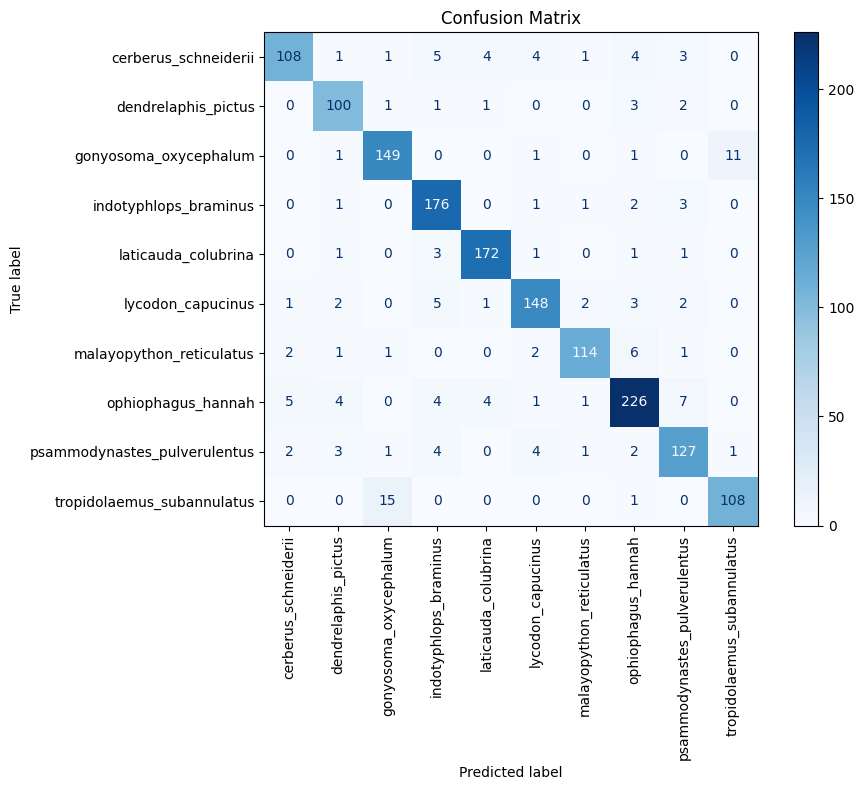

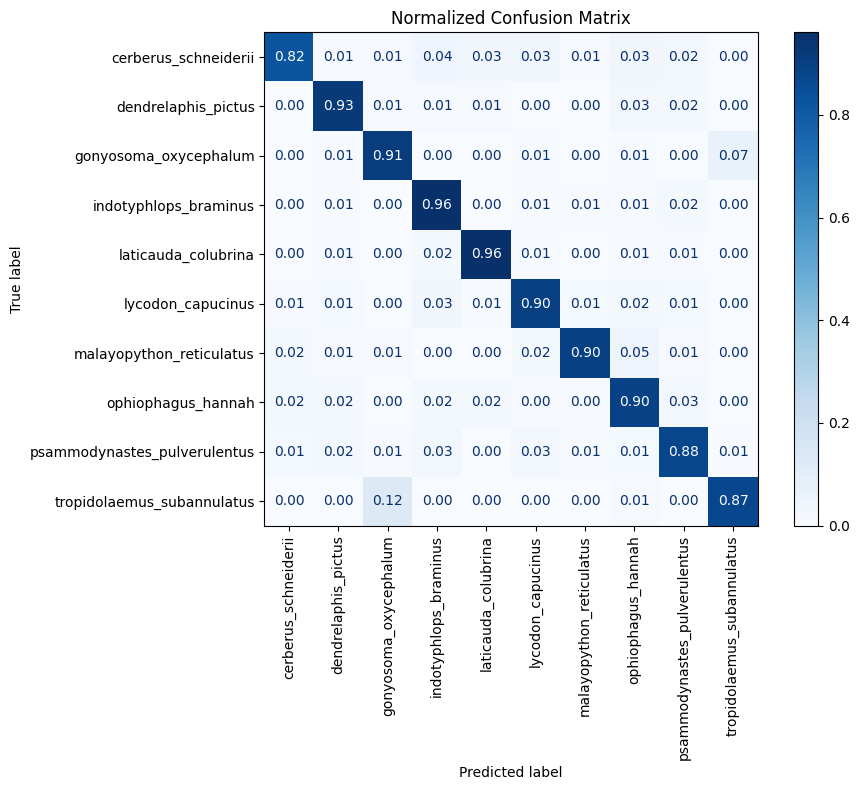

In [88]:
# ============================================
# 6. CONFUSION MATRIX (VISUAL)
# ============================================

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Normalized confusion matrix (optional)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90, values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


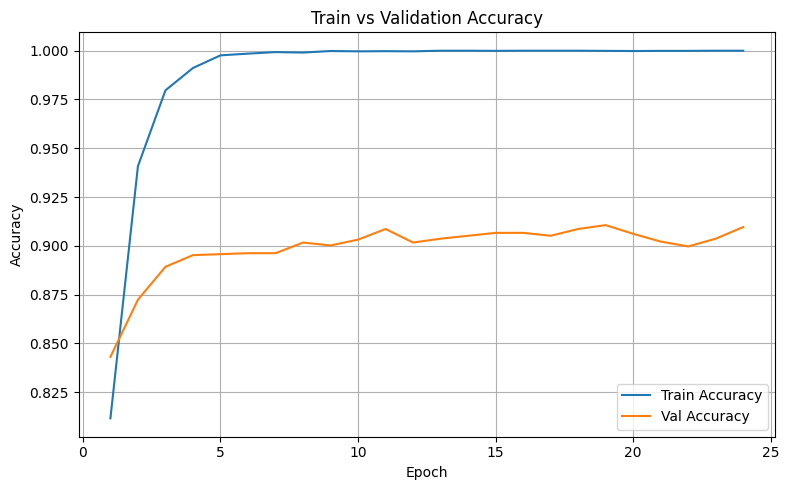

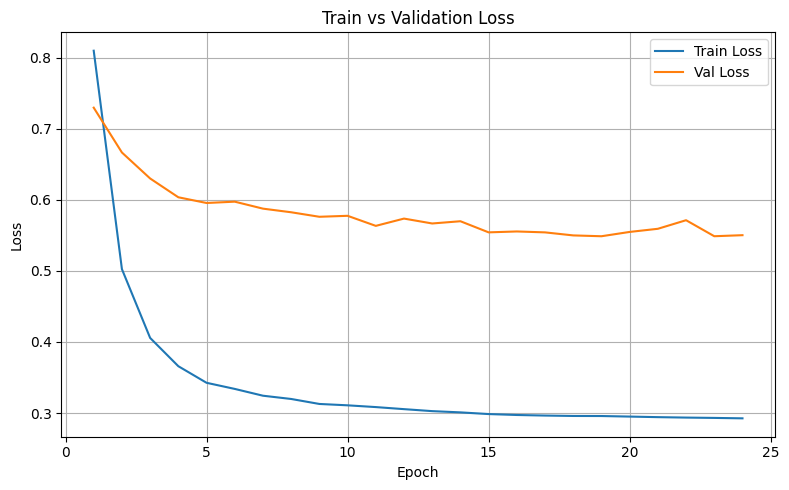

In [89]:
# ============================================
# 7. TRAIN vs VAL ACCURACY & LOSS PLOTS
# ============================================

# Accuracy
acc     = history_stage2.history.get("accuracy") or history.history.get("categorical_accuracy")
val_acc = history_stage2.history.get("val_accuracy") or history.history.get("val_categorical_accuracy")

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
loss     = history_stage2.history["loss"]
val_loss = history_stage2.history["val_loss"]

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [90]:
import numpy as np
import tensorflow as tf

# ---------------------------------------------------------
# 1) Collect probabilities and true labels from val_ds
# ---------------------------------------------------------
all_probs = []
all_labels = []

for batch_x, batch_y in val_ds:
    # model outputs softmax probs
    batch_probs = model.predict(batch_x, verbose=0)
    all_probs.append(batch_probs)

    # batch_y might be one-hot (categorical) or integers (sparse)
    all_labels.append(batch_y.numpy())

probs = np.concatenate(all_probs, axis=0)       # shape: (N, num_classes)
labels = np.concatenate(all_labels, axis=0)     # shape: (N,) or (N, num_classes)

num_classes = probs.shape[1]

# Ensure labels are one-hot
if labels.ndim == 1:  # sparse int labels
    y_true = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
else:
    y_true = labels

y_true = y_true.astype("float32")

print("Validation predictions collected:")
print("probs shape:", probs.shape)
print("y_true shape:", y_true.shape)

# ---------------------------------------------------------
# 2) Helper functions for temperature scaling
# ---------------------------------------------------------
def apply_temperature(probs, T):
    """
    Apply temperature scaling directly on probabilities:
    softmax(z/T) = normalize( softmax(z) ** (1/T) )
    So we can work with probs without needing logits.
    """
    probs = np.asarray(probs, dtype="float64")
    scaled = probs ** (1.0 / T)
    scaled /= np.sum(scaled, axis=1, keepdims=True) + 1e-12
    return scaled

def nll(probs, y_true):
    """Negative log-likelihood (cross-entropy) for already-softmaxed probs."""
    eps = 1e-8
    log_p = np.log(probs + eps)
    return -np.mean(np.sum(y_true * log_p, axis=1))

# ---------------------------------------------------------
# 3) Grid search over T to find best calibration
# ---------------------------------------------------------
Ts = np.linspace(0.5, 3.0, 26)  # try T from 0.5 to 3.0
best_T = 1.0
base_nll = nll(probs, y_true)
best_nll = base_nll

for T in Ts:
    scaled = apply_temperature(probs, T)
    score = nll(scaled, y_true)
    if score < best_nll:
        best_nll = score
        best_T = T

print(f"\nBase NLL (T=1.0): {base_nll:.4f}")
print(f"Best T: {best_T:.3f} with NLL: {best_nll:.4f}")

# Save globally for later inference
TEMPERATURE = 0.9


Validation predictions collected:
probs shape: (2014, 10)
y_true shape: (2014, 10)

Base NLL (T=1.0): 0.3326
Best T: 0.900 with NLL: 0.3243


Found 2 images in E:\Snake_Identification_Folder\test_images
Testing on 2 random images.



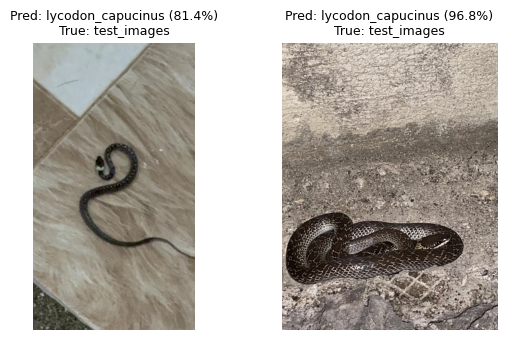

In [111]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from pathlib import Path
from PIL import Image

# ---------------------------------------------------
# ASSUMED ALREADY DEFINED IN YOUR NOTEBOOK:
#   model        -> trained MobileNetV3 model
#   class_names  -> list of class names in index order
#   img_size     -> e.g. (224, 224) or (320, 320)
#   TEMPERATURE  -> from the calibration cell above
# ---------------------------------------------------

# ===== helper: temperature scaling on a single prediction =====
def calibrate_probs(probs, T):
    """
    probs: np.array shape (num_classes,)
    Returns calibrated probabilities with temperature T.
    """
    probs = np.asarray(probs, dtype="float64")
    scaled = probs ** (1.0 / T)
    scaled /= np.sum(scaled, keepdims=True) + 1e-12
    return scaled.astype("float32")

# You can choose a threshold for "uncertain"
CONFIDENCE_THRESHOLD = 0.80  # e.g. 60%


# ===========================================
# 1. SET FOLDER WITH YOUR INTERNET IMAGES
# ===========================================
CUSTOM_TEST_ROOT = Path(r"E:\Snake_Identification_Folder\test_images")
INFER_TRUE_FROM_FOLDER = True  # use folder name as "true" label


# ===========================================
# 2. COLLECT ALL IMAGES FROM THAT FOLDER
# ===========================================
image_paths = [
    p for p in CUSTOM_TEST_ROOT.rglob("*")
    if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".webp", ".bmp"]
]

print(f"Found {len(image_paths)} images in {CUSTOM_TEST_ROOT}")

if not image_paths:
    raise RuntimeError("No images found. Check CUSTOM_TEST_ROOT path and contents.")

num_samples = min(15, len(image_paths))
sample_paths = random.sample(image_paths, num_samples)
print(f"Testing on {num_samples} random images.\n")

# ===========================================
# 3. PREDICT AND DISPLAY
# ===========================================
cols = min(5, num_samples)
rows = int(np.ceil(num_samples / cols))

plt.figure(figsize=(3 * cols, 3.5 * rows))

for i, img_path in enumerate(sample_paths, start=1):
    # Load & resize image
    orig_img = Image.open(img_path).convert("RGB")
    img_resized = orig_img.resize(img_size)

    # Preprocess (same as training)
    img_array = tf.keras.utils.img_to_array(img_resized)
    img_array = tf.expand_dims(img_array, 0)      # (1, H, W, 3)
    img_array = preprocess_input(img_array)

    # Raw model prediction (softmax probs)
    raw_preds = model.predict(img_array, verbose=0)[0]

    # Apply temperature scaling
    calibrated = calibrate_probs(raw_preds, TEMPERATURE)

    # Final prediction
    pred_idx = int(np.argmax(calibrated))
    pred_class = class_names[pred_idx]
    confidence = float(calibrated[pred_idx])

    # Optional "true" label from folder name
    if INFER_TRUE_FROM_FOLDER:
        true_class = img_path.parent.name
    else:
        true_class = "Unknown"

    # If not confident enough, mark as uncertain
    if confidence < CONFIDENCE_THRESHOLD:
        display_class = f"Uncertain ({pred_class})"
    else:
        display_class = pred_class

    # Plot
    plt.subplot(rows, cols, i)
    plt.imshow(orig_img)
    plt.axis("off")
    title = f"Pred: {display_class} ({confidence:.1%})\nTrue: {true_class}"
    plt.title(title, fontsize=9)

plt.tight_layout()
plt.show()


Using last conv layer for Grad-CAM: conv_1
Predicted class : lycodon_capucinus
Confidence      : 94.85%


C:\Users\Philip\AppData\Local\Temp\ipykernel_19168\933804217.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]


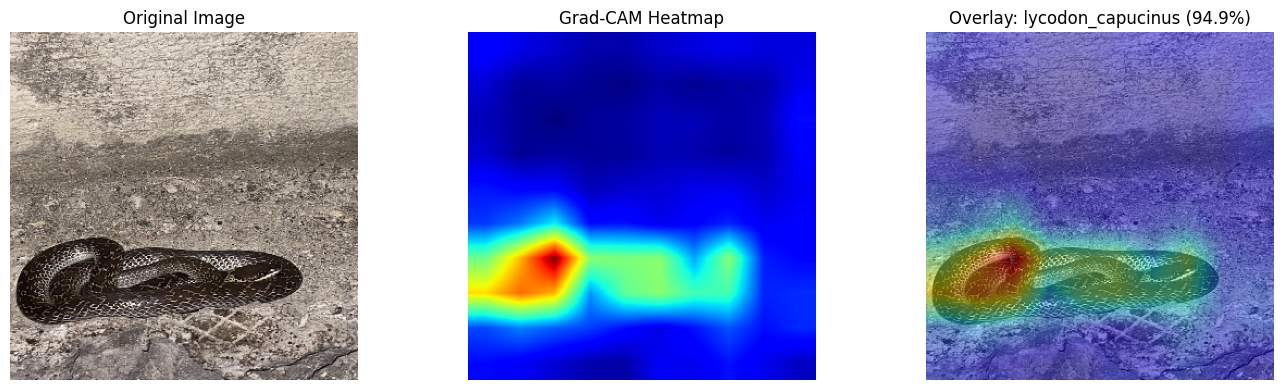

In [112]:
# ============================================
# Grad-CAM visualization for current model
# ============================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from PIL import Image

# 1. Find the last Conv2D layer automatically (works for MobileNetV3Large)
last_conv_layer = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer = layer
        break

if last_conv_layer is None:
    raise ValueError("No Conv2D layer found in the model for Grad-CAM.")

print("Using last conv layer for Grad-CAM:", last_conv_layer.name)

# 2. Build a model that maps input -> (last_conv_output, predictions)
grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

def load_and_preprocess_image(img_path):
    """Load image from path and preprocess exactly like training."""
    img = keras_image.load_img(img_path, target_size=img_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array

def make_gradcam_heatmap(img_array, pred_index=None):
    """Compute Grad-CAM heatmap for a single preprocessed image."""
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of the predicted class wrt conv layer output
    grads = tape.gradient(class_channel, conv_outputs)

    # Global average pooling over H,W
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    conv_outputs = conv_outputs[0]  # (H, W, C)
    heatmap = tf.tensordot(conv_outputs, pooled_grads, axes=(2, 0))

    # ReLU + normalize to [0,1]
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()  # (H, W)

def show_gradcam(image_path, alpha=0.4):
    """Display original, heatmap, and overlay for a given image path."""
    # Load + preprocess
    orig_img, img_array = load_and_preprocess_image(image_path)

    # Predict
    preds = model.predict(img_array, verbose=0)
    pred_idx = int(np.argmax(preds[0]))
    pred_class = class_names[pred_idx]
    confidence = float(preds[0][pred_idx])

    print(f"Predicted class : {pred_class}")
    print(f"Confidence      : {confidence:.2%}")

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, pred_index=pred_idx)

    # Resize heatmap to match model input size
    heatmap_resized = tf.image.resize(
        heatmap[..., np.newaxis],
        img_size
    ).numpy().squeeze()

    # Convert to color map
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_uint8]  # (H, W, 3)
    jet_heatmap = np.uint8(255 * jet_heatmap)

    # Prepare base image (resize to model input size for overlay)
    base_img = orig_img.resize(img_size)
    base_img = np.array(base_img)

    # Overlay heatmap on image
    overlay = np.uint8(base_img * (1 - alpha) + jet_heatmap * alpha)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    axes[0].imshow(orig_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(heatmap_resized, cmap="jet")
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title(f"Overlay: {pred_class} ({confidence:.1%})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# ============================================
# USAGE: set your image path here then run show_gradcam(...)
# ============================================
IMAGE_PATH = r"E:\Snake_Identification_Folder\test_images\601817391_2337950920006164_4384189328983742618_n.jpg"  # <-- edit this
show_gradcam(IMAGE_PATH)


In [113]:
import os
import numpy as np

# Choose ONE filename that ends with `.weights.h5`
weights_filename = "best_mobilenetv3_snakes.weights.h5"
classnames_filename = "class_names.txt"

# 1. Save model weights
model.save_weights(weights_filename)
print(f"✅ Saved weights to {weights_filename}")

# 2. Save class names (one per line)
with open(classnames_filename, "w") as f:
    for name in class_names:
        f.write(name + "\n")
print(f"✅ Saved class names to {classnames_filename}")

# 3. Verify they exist in the current working directory
print("Current working dir:", os.getcwd())
print("Weights exists:", os.path.exists(weights_filename))
print("Class names exists:", os.path.exists(classnames_filename))


✅ Saved weights to best_mobilenetv3_snakes.weights.h5
✅ Saved class names to class_names.txt
Current working dir: e:\Snake_Identification_Folder
Weights exists: True
Class names exists: True


In [114]:
# === REBUILD MODEL + LOAD WEIGHTS + EXPORT TO ONNX (ONE CELL, WITH AUTO-INSTALL) ===
import os
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers

# Try to import tf2onnx, install if missing
try:
    import tf2onnx
except ImportError:
    import subprocess, sys
    print("tf2onnx not found. Installing tf2onnx...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    import tf2onnx

# ----------------------------------------------------
# CONFIG – EDIT IF NEEDED
# ----------------------------------------------------
IMG_SIZE = (320, 320)  # 👈 same size you used in training
WEIGHTS_PATH = "best_mobilenetv3_snakes.weights.h5"
CLASS_NAMES_PATH = "class_names.txt"
ONNX_OUTPUT_PATH = "best_mobilenetv3_snakes.onnx"

# ----------------------------------------------------
# 1. Load class names (must match training order)
# ----------------------------------------------------
if not os.path.exists(CLASS_NAMES_PATH):
    raise FileNotFoundError(f"Could not find {CLASS_NAMES_PATH} in {os.getcwd()}")

with open(CLASS_NAMES_PATH, "r") as f:
    class_names = [line.strip() for line in f if line.strip()]

num_classes = len(class_names)
print("✅ Loaded class names:", class_names)
print("Number of classes:", num_classes)

# ----------------------------------------------------
# 2. Rebuild the SAME architecture as during training
#    (MobileNetV3Small + Dropout(0.5) + Dense(num_classes, softmax))
# ----------------------------------------------------
base = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None,         # we will load YOUR fine-tuned weights
    pooling="avg",
)

base.trainable = True  # for inference this doesn't matter, but it's fine

x = layers.Dropout(0.5, name="dropout")(base.output)
outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs=base.input, outputs=outputs, name="mobilenetv3_snakes")

# ----------------------------------------------------
# 3. Load trained weights
# ----------------------------------------------------
if not os.path.exists(WEIGHTS_PATH):
    raise FileNotFoundError(f"Could not find {WEIGHTS_PATH} in {os.getcwd()}")

model.load_weights(WEIGHTS_PATH)
print(f"✅ Loaded weights from: {WEIGHTS_PATH}")

model.summary()

# ----------------------------------------------------
# 4. Convert to ONNX (for Raspberry Pi / onnxruntime)
# ----------------------------------------------------
input_signature = (
    tf.TensorSpec(shape=(1, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32, name="input"),
)

onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=input_signature,
    opset=13,
    output_path=ONNX_OUTPUT_PATH,
)

print(f"\n✅ ONNX model saved to: {ONNX_OUTPUT_PATH}")


✅ Loaded class names: ['cerberus_schneiderii', 'dendrelaphis_pictus', 'gonyosoma_oxycephalum', 'indotyphlops_braminus', 'laticauda_colubrina', 'lycodon_capucinus', 'malayopython_reticulatus', 'ophiophagus_hannah', 'psammodynastes_pulverulentus', 'tropidolaemus_subannulatus']
Number of classes: 10
✅ Loaded weights from: best_mobilenetv3_snakes.weights.h5


Model: "mobilenetv3_snakes"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 320, 320,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 160, 160,  │        432 │ rescaling_3[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 160, 160,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 160, 160,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │        144 │ activation_60[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 160, 160,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_57 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │        256 │ re_lu_57[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 160, 160,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 160, 160,  │          0 │ activation_60[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 160, 160,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_58 (ReLU)     │ (None, 160, 160,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 161, 161,  │          0 │ re_lu_58[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 80, 80,    │        256 │ expanded_conv_1_

 Total params: 3,005,962 (11.47 MB)

 Trainable params: 2,981,562 (11.37 MB)

 Non-trainable params: 24,400 (95.31 KB)


✅ ONNX model saved to: best_mobilenetv3_snakes.onnx
